In [242]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas_datareader import data, wb
from datetime import datetime, timedelta
import numpy as np
%matplotlib inline
import sqlite3

# Ativos da Carteira

In [243]:
conn = sqlite3.connect('ativos.db')
cursor = conn.cursor()
#Cria o array de ativos e dos ativos com quantidade
query =" SELECT sigla, qtd FROM ativos WHERE moeda <> 'DIGITAL' AND moeda <> 'FI';"
cursor.execute(query)
ativos_qtd = {}
ativos = []
pesos = []
for linha in cursor:
    ativos_qtd[linha[0]] = linha[1] 
    ativos.append(linha[0]) 
conn.close()


In [244]:
start = datetime(2018,1,1)
ativos

['ABEV3.SA', 'ENBR3.SA', 'ITUB3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ITSA4.SA']

In [245]:
#ativos/ações 
tickers= ativos

#busca os ativos de acordo com a data inicial 
acoes=pd.DataFrame()
for t in tickers:
    acoes[t]= data.DataReader(t, data_source='yahoo', start=start)['Adj Close']


In [246]:
acoes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2018-01-02 to 2021-01-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ABEV3.SA  756 non-null    float64
 1   ENBR3.SA  756 non-null    float64
 2   ITUB3.SA  756 non-null    float64
 3   ITUB4.SA  756 non-null    float64
 4   BBDC4.SA  756 non-null    float64
 5   ITSA4.SA  756 non-null    float64
dtypes: float64(6)
memory usage: 41.3 KB


In [247]:
#ultima cotacao
acoes.tail(1)

,ABEV3.SA,ENBR3.SA,ITUB3.SA,ITUB4.SA,BBDC4.SA,ITSA4.SA
Date,,,,,,
2021-01-27,15.39,19.27,25.280001,28.120001,24.370001,10.5


In [248]:
#Calcula o valor total das acoes na carteira - (ativo * qtd)
total = 0.0
for key, value in ativos_qtd.items():
    total += (acoes[key].tail(1).sum() * value)

#cria o array de  peso do ativos contidos na carteira    
pesos = []
for key, value in ativos_qtd.items():
     #"%.4f" % (acoes[key].tail(1).sum() *  value / total)
    pesos.append(round(acoes[key].tail(1).sum() *  value / total,4))

conn.close()    
#pega ultima cotação


In [249]:
pesos

[0.1355, 0.2005, 0.2226, 0.1125, 0.0683, 0.2606]

In [250]:
#weights = np.array([0.2103,0.1383,0.2540,0.1187,0.0728,0.2059])
#weights = np.array(pesos)
total

2498.550048828125

# Retornos

In [251]:
#retorno diario dos aivos
returns = acoes / acoes.shift(1) - 1
returns.head()

,ABEV3.SA,ENBR3.SA,ITUB3.SA,ITUB4.SA,BBDC4.SA,ITSA4.SA
Date,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.002305,-0.045070,0.007796,0.006837,0.004597,0.011786
2018-01-04,-0.005520,0.001475,0.011088,0.020824,0.016408,0.018817
2018-01-05,0.003700,-0.008836,0.006886,0.002883,0.005664,0.001759
2018-01-08,-0.001843,0.016345,-0.005572,-0.003316,-0.000281,-0.000878


# Obtendo a Fronteira Eficiente Markowitz

In [252]:
log_returns = np.log(acoes / acoes.shift(1)) 
log_returns.max()

ABEV3.SA    0.094139
ENBR3.SA    0.144581
ITUB3.SA    0.104657
ITUB4.SA    0.104894
BBDC4.SA    0.155866
ITSA4.SA    0.095604
dtype: float64

In [253]:
#retorno anual
log_returns.mean() * 250

ABEV3.SA   -0.084179
ENBR3.SA    0.158001
ITUB3.SA    0.046909
ITUB4.SA    0.032435
BBDC4.SA    0.052359
ITSA4.SA    0.075233
dtype: float64

In [254]:
log_returns.cov() * 250

,ABEV3.SA,ENBR3.SA,ITUB3.SA,ITUB4.SA,BBDC4.SA,ITSA4.SA
ABEV3.SA,0.114809,0.049020,0.058442,0.063325,0.074996,0.062739
ENBR3.SA,0.049020,0.111577,0.053512,0.060104,0.072184,0.063493
ITUB3.SA,0.058442,0.053512,0.099291,0.104297,0.112661,0.097280
ITUB4.SA,0.063325,0.060104,0.104297,0.126434,0.131047,0.115477
BBDC4.SA,0.074996,0.072184,0.112661,0.131047,0.165226,0.123635
ITSA4.SA,0.062739,0.063493,0.097280,0.115477,0.123635,0.119477


In [255]:
#correlação entre os ativos
log_returns.corr()

,ABEV3.SA,ENBR3.SA,ITUB3.SA,ITUB4.SA,BBDC4.SA,ITSA4.SA
ABEV3.SA,1.000000,0.433108,0.547369,0.525599,0.544518,0.535683
ENBR3.SA,0.433108,1.000000,0.508408,0.506037,0.531637,0.549917
ITUB3.SA,0.547369,0.508408,1.000000,0.930865,0.879587,0.893159
ITUB4.SA,0.525599,0.506037,0.930865,1.000000,0.906687,0.939557
BBDC4.SA,0.544518,0.531637,0.879587,0.906687,1.000000,0.879960
ITSA4.SA,0.535683,0.549917,0.893159,0.939557,0.879960,1.000000


In [256]:
num_assets = len(tickers)
num_assets

6

In [257]:
weights = np.random.random(num_assets)
weights /= np.sum(weights)
#weights = np.array(pesos)
weights

array([0.09598621, 0.28576081, 0.11342003, 0.3271196 , 0.12960622,
       0.04810713])

In [258]:
#weights[0] + weights[1] + weights[2] + weights[3] + weights[4] + weights[5] +  weights[6] +  weights[7] + weights[8]
weights[0] + weights[1] + weights[2] + weights[3] + weights[4] + weights[5] 

0.9999999999999999

In [259]:
#Expected Portofolio Retrun
np.sum(weights * log_returns.mean()) * 250

0.06340608930439484

In [260]:
#Expected Portofolio Variance
np.dot(weights.T, np.dot(log_returns.cov() * 250, weights))

0.08861056069618646

In [261]:
#Expected Portofolio Volatility
np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 250, weights)))

0.2976752604705108

In [262]:
pfolio_returns =[]
pfolio_volatilities = []

for x in range(360):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_returns.append(np.sum(weights * log_returns.mean()) * 250)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 250, weights))))

pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)

pfolio_returns



array([0.06918035, 0.06668265, 0.02501625, 0.04239023, 0.064953  ,
       0.01377043, 0.02146273, 0.0179277 , 0.04930137, 0.03912527,
       0.08365104, 0.0456826 , 0.04491579, 0.04279214, 0.04818289,
       0.02742782, 0.02744666, 0.04535757, 0.07577393, 0.05986834,
       0.07430489, 0.03423819, 0.00888554, 0.05485861, 0.0551627 ,
       0.02792754, 0.04208998, 0.03627666, 0.06348053, 0.02911428,
       0.02305536, 0.0249026 , 0.05567359, 0.0782574 , 0.05557577,
       0.01619739, 0.04290696, 0.07547624, 0.03973964, 0.05690849,
       0.03657142, 0.04649278, 0.02883883, 0.00108625, 0.02223986,
       0.07028902, 0.04712241, 0.06071903, 0.01694183, 0.01925954,
       0.053034  , 0.03975097, 0.05934223, 0.07319671, 0.03853392,
       0.0314066 , 0.06102666, 0.06872491, 0.04968392, 0.05241066,
       0.07114359, 0.04827353, 0.06150254, 0.04834651, 0.02676492,
       0.05459798, 0.024567  , 0.07066357, 0.04072412, 0.06082841,
       0.05323649, 0.04439742, 0.0243829 , 0.04312833, 0.01419

In [263]:
pfolio_volatilities

array([0.30468885, 0.29842327, 0.27841848, 0.28963989, 0.31352065,
       0.31208144, 0.30645756, 0.31097623, 0.29290953, 0.28215645,
       0.30497008, 0.32734813, 0.28469992, 0.28107069, 0.30765429,
       0.31652873, 0.28723525, 0.33126187, 0.29276335, 0.32742517,
       0.31774479, 0.28043575, 0.31673714, 0.29516709, 0.30314549,
       0.29364986, 0.29956975, 0.30269537, 0.31133783, 0.28995228,
       0.30961977, 0.29832163, 0.29823193, 0.29852753, 0.30221908,
       0.2995663 , 0.28963532, 0.30506187, 0.31810468, 0.31343993,
       0.31113632, 0.28865163, 0.29339929, 0.29919368, 0.31584275,
       0.30572692, 0.28782749, 0.29363541, 0.31771428, 0.29927674,
       0.32264548, 0.29615254, 0.30085701, 0.29585667, 0.3068473 ,
       0.30619886, 0.29635577, 0.30236531, 0.32865157, 0.29568835,
       0.30858166, 0.30580797, 0.30379283, 0.30207323, 0.30527137,
       0.29590024, 0.31339211, 0.31475316, 0.31991367, 0.30901922,
       0.30585383, 0.2989189 , 0.29038005, 0.30439109, 0.29605

In [264]:
pfolio = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})

In [265]:
pfolio.head()

,Return,Volatility
0,0.069180,0.304689
1,0.066683,0.298423
2,0.025016,0.278418
3,0.042390,0.289640
4,0.064953,0.313521


In [266]:
pfolio.tail()

,Return,Volatility
355,0.079067,0.302530
356,0.015129,0.293538
357,0.049935,0.308469
358,0.015180,0.298895
359,0.068164,0.318705


Text(0, 0.5, 'Expected Return')

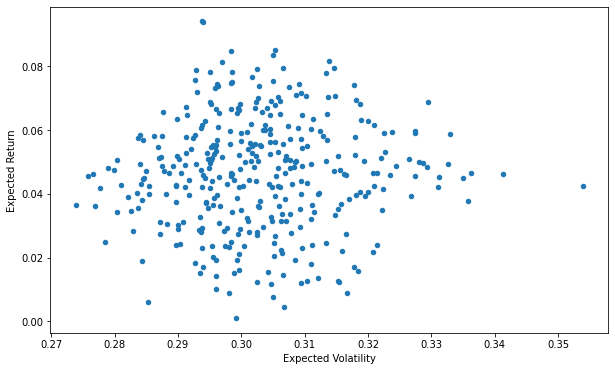

In [267]:
pfolio.plot(x='Volatility', y='Return', kind='scatter', figsize=(10,6))
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')


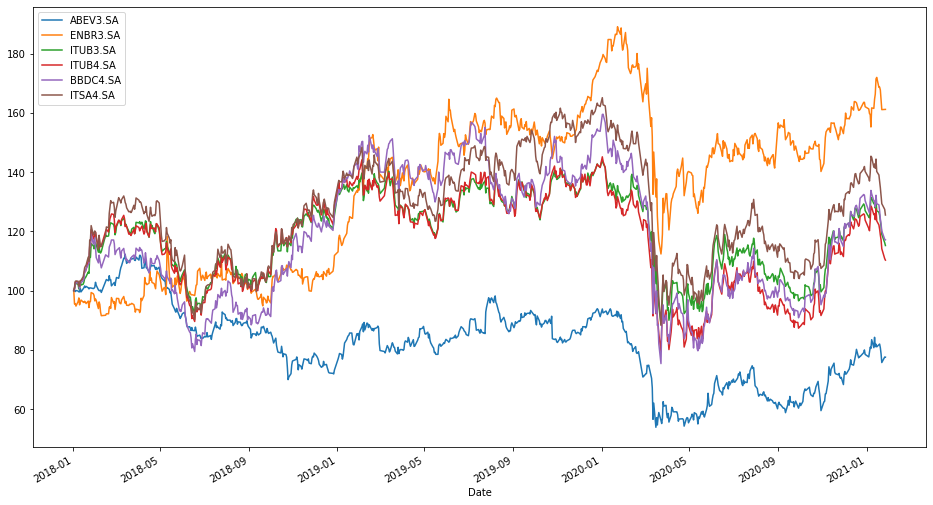

In [268]:
#normaliza atual / primeira * 100 neste caso toda a primeira será 100 tendo assim um ponto de referência
#evolução das ações(dados do yahoo finance)
(acoes / acoes.iloc[0] * 100).plot(figsize = (16,9));
plt.legend()
plt.show()

In [269]:
#retornos anuais dos ativos
retornos_anual = returns.mean() * 250
retornos_anual

ABEV3.SA   -0.027200
ENBR3.SA    0.213747
ITUB3.SA    0.096492
ITUB4.SA    0.095578
BBDC4.SA    0.134894
ITSA4.SA    0.134783
dtype: float64

In [270]:
# Retorno anual da carteira com seus respectivos pesos - pega os valores do yahoo finance. 
portofolio_1 = str(round(np.dot(retornos_anual, pesos),5) *100) + ' %'
#portofolio_1 = str(round(np.dot(retornos_anual, weights) *100, 5)) + ' %'
print(portofolio_1) 


11.574 %


# Correlação

In [271]:
def plot_corr(corr):
    # Cortaremos a metade de cima pois é o espelho da metade de baixo
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True

    sns.heatmap(corr, mask=mask, cmap='RdBu', center=0, square=True, linewidths=.5,annot=True  )

,ABEV3.SA,ENBR3.SA,ITUB3.SA,ITUB4.SA,BBDC4.SA,ITSA4.SA
ABEV3.SA,1.000000,-0.327373,0.415555,0.537158,0.329256,0.335608
ENBR3.SA,-0.327373,1.000000,0.459980,0.303439,0.557783,0.607860
ITUB3.SA,0.415555,0.459980,1.000000,0.977595,0.952801,0.963196
ITUB4.SA,0.537158,0.303439,0.977595,1.000000,0.927711,0.912468
BBDC4.SA,0.329256,0.557783,0.952801,0.927711,1.000000,0.932121
ITSA4.SA,0.335608,0.607860,0.963196,0.912468,0.932121,1.000000


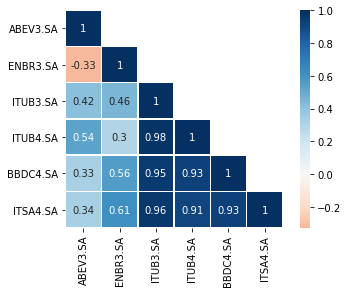

In [272]:
#Correlações entre os ativos da carteira
#plt.figure(figsize=(16,8))
plot_corr(acoes.corr())
acoes.corr()

In [273]:
#plt.figure(figsize=(10,6))
#sns.heatmap(acoes.corr() ,cmap='RdBu', square=True, linewidths=.2,annot=True)


In [274]:
acoes.skew()

ABEV3.SA   -0.049336
ENBR3.SA   -0.190048
ITUB3.SA   -0.235560
ITUB4.SA   -0.354172
BBDC4.SA    0.045550
ITSA4.SA    0.057617
dtype: float64

In [275]:
acoes.kurt(axis=1)

Date
2018-01-02   -0.972459
2018-01-03   -1.217283
2018-01-04   -1.253092
2018-01-05   -1.307210
2018-01-08   -1.242709
                ...   
2021-01-20   -1.329157
2021-01-21   -1.377879
2021-01-22   -1.476841
2021-01-26   -1.161130
2021-01-27   -1.073534
Length: 756, dtype: float64

array([[<AxesSubplot:title={'center':'ABEV3.SA'}>,
        <AxesSubplot:title={'center':'ENBR3.SA'}>],
       [<AxesSubplot:title={'center':'ITUB3.SA'}>,
        <AxesSubplot:title={'center':'ITUB4.SA'}>],
       [<AxesSubplot:title={'center':'BBDC4.SA'}>,
        <AxesSubplot:title={'center':'ITSA4.SA'}>]], dtype=object)

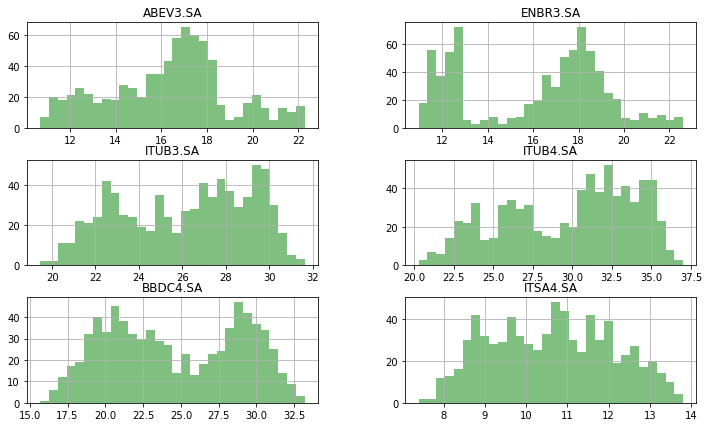

In [276]:
#ACOES

acoes[['ABEV3.SA','ENBR3.SA','ITUB3.SA','ITUB4.SA','BBDC4.SA','ITSA4.SA']].hist(bins=30,alpha=0.5,color='Green',figsize=(12,7))

In [277]:
#FUNDOS IMOBILIARIOS
acoes[['XPML11.SA','XPIN11.SA','XPLG11.SA']].hist(bins=30,alpha=0.5,color='Green',figsize=(10,6))

KeyError: "None of [Index(['XPML11.SA', 'XPIN11.SA', 'XPLG11.SA'], dtype='object')] are in the [columns]"